In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import place_poles

from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are


from plotfunc import plot_sets

In [2]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q=np.array([[1,0],
            [0,1]])

R=np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

print(f"Macierz P:")
print(P)

Macierz P:
[[1.59270823 0.0472136 ]
 [0.0472136  0.13189887]]


In [ ]:
R_inv = np.linalg.inv(R) # Odwrotność macierzy R
K = R_inv @ B.T @ P

print("Macierz Wzmocnień K:")
print(K) 


Macierz Wzmocnień K:
[[0.23606798 0.65949437]]


In [5]:
def model(x,t):
    R=0.5
    L=0.2
    C=0.5
    u=np.array([[1]])

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])

    dx=A@x+(B*u).flatten()
    return dx

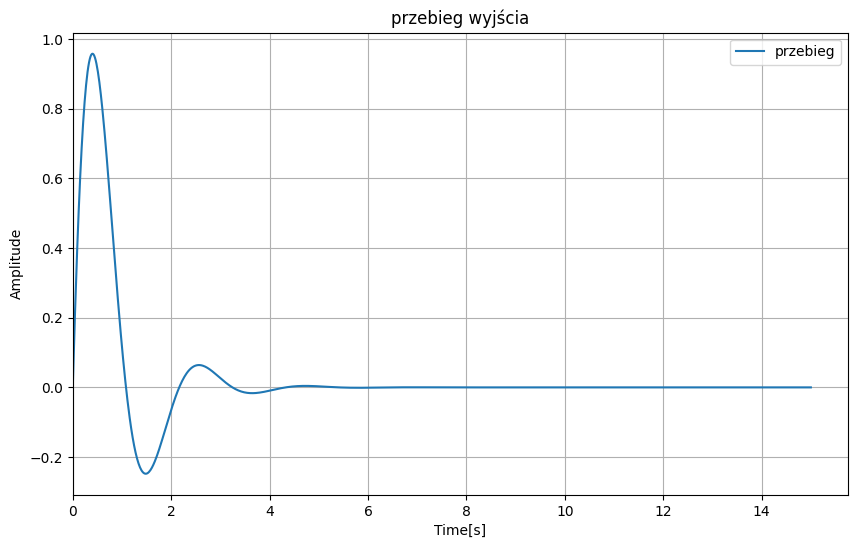

In [6]:
x0 = np.array([0, 0])

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [ ]:
def model_with_K(x,t,K):
    R=0.5
    L=0.2
    C=0.5
    u=-K@x

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    dx=A@x+(B*u).flatten()
    return dx

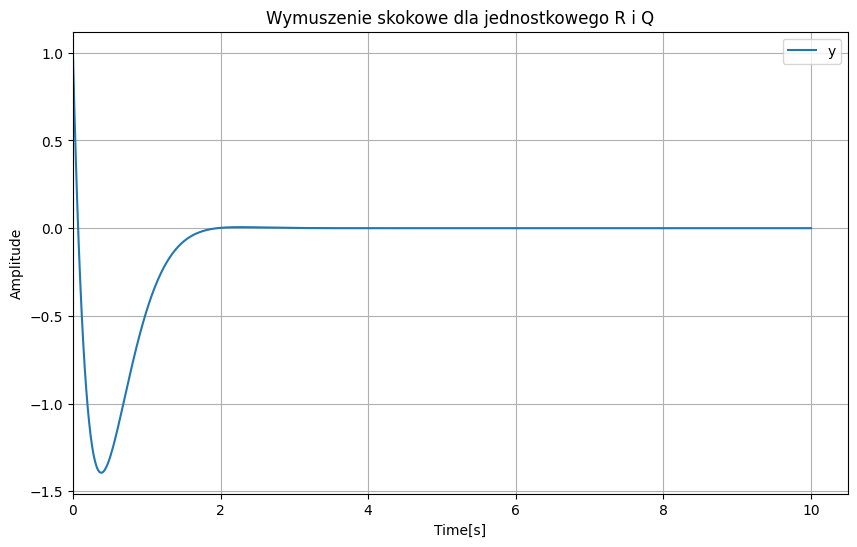

In [25]:
x0 = np.array([1, 1])

t = np.linspace(0, 10, 1000)

x = odeint(model_with_K, x0, t,args=(K,))

y = x[:, 1]
plot_sets('Wymuszenie skokowe dla jednostkowego R i Q',[t,y,'y'])

In [9]:
R1=np.array([[1]]) #"koszt" energetyczny 
Q1=np.array([[10,0], #"koszt" stanu 
             [0,10]])

P1 = solve_continuous_are(A, B, Q1, R1)
R1_inv = np.linalg.inv(R1) 
K1 = R1_inv @ B.T @ P1

R2=np.array([[10]])
Q2=np.array([[1,0],
             [0,1]])

P2 = solve_continuous_are(A, B, Q2, R2)
R2_inv = np.linalg.inv(R2) 
K2 = R2_inv @ B.T @ P2

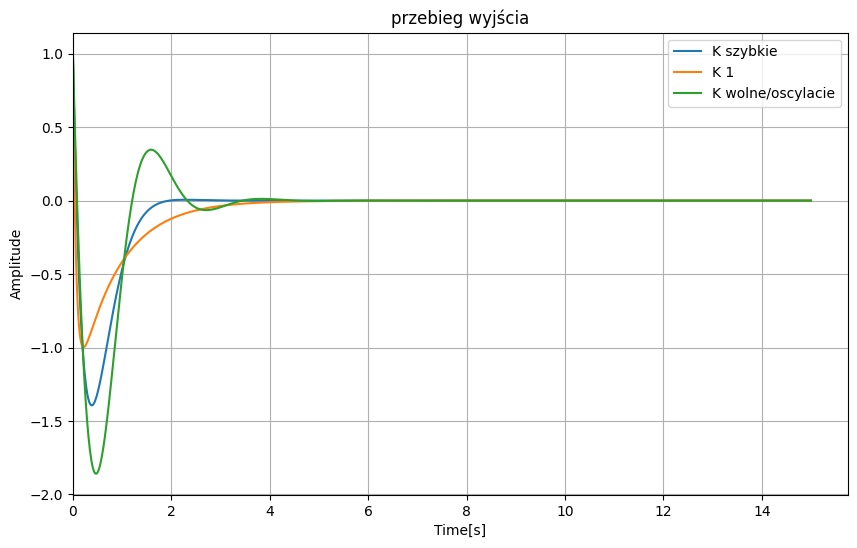

In [10]:

x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x1 = odeint(model_with_K, x0, t,args=(K,))
x2=odeint(model_with_K, x0, t,args=(K1,))
x3=odeint(model_with_K, x0, t,args=(K2,))


y1 = x1[:, 1]
y2 = x2[:, 1]
y3 = x3[:, 1]

plot_sets('przebieg wyjścia',[t,y1,'K szybkie'],
          [t,y2,'K 1'],
          [t,y3,'K wolne/oscylacie'])

In [19]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

def model_cost_function(x_roz, t, K, Q, R_wag):
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    # Krok 2: Sygnał sterujący (u)
    # u = -Kx (skalar)
    u = -K @ x 
    u_mat = np.array([[u]]) # Macierz 1x1 dla u

    # Krok 3: Obliczenie pochodnych stanu nominalnego (x_dot)
    # x_dot = A@x + B@u
    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    # Krok 4: Obliczenie wyrażenia podcałkowego J_dot
    # J_dot = x^T * Q * x + u^T * R_wag * u
    cost_integrand = x_vec.T @ Q @ x_vec + u_mat.T @ R_wag @ u_mat
    
    
    # x_dot_nominal musi być spłaszczony do wektora 1D, aby konkatenacja była poprawna
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    cost_flat = cost_integrand.flatten()
    
    return np.concatenate((x_dot_nominal, cost_flat))

In [12]:
x0 = np.array([1, 1, 0])

t = np.linspace(0, 15, 1000)

R_w=np.array([[1]])

sol_LQR = odeint(model_cost_function, x0, t, args=(K, Q, R_w))
J_LQR = sol_LQR[-1, 2] # Wartość J_akum w ostatniej chwili

# Symulacja dla innych wzmocnień (nieoptymalne)
sol_Inne = odeint(model_cost_function, x0, t, args=(K1, Q1, R1))
J_Inne = sol_Inne[-1, 2]

sol_Inne2 = odeint(model_cost_function, x0, t, args=(K1, Q2, R2))
J_Inne2 = sol_Inne2[-1, 2]

print(f"Wartość wskaźnika J dla wzmocnień LQR: {J_LQR:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne2:.4f}")

Wartość wskaźnika J dla wzmocnień LQR: 1.8190
Wartość wskaźnika J dla innych wzmocnień: 12.6379
Wartość wskaźnika J dla innych wzmocnień: 15.1932


# 3 skonczony horyzont czasowy 


In [58]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q = np.eye(2)
R = np.array([[1.0]]) *10
R_inv = np.linalg.inv(R)

def riccati(p,t):
    P=p.reshape((2, 2))

    P_dot = (P@A-P@B@R_inv@B.T@P+A.T@P+Q)*-1

    p_dot = P_dot.flatten()

    return p_dot

[[ 3.89621967  0.65242479  0.65242479  0.47571728]
 [ 4.03118018  0.68541245  0.68541245  0.48201741]
 [ 4.1739372   0.71897078  0.71897078  0.4881113 ]
 [ 4.32467253  0.75302522  0.75302522  0.49397389]
 [ 4.48355199  0.78749321  0.78749321  0.49957958]
 [ 4.65072285  0.8222838   0.8222838   0.50490238]
 [ 4.82631129  0.85729739  0.85729739  0.50991599]
 [ 5.01041953  0.89242541  0.89242541  0.51459398]
 [ 5.20312292  0.92755008  0.92755008  0.51890994]
 [ 5.40446681  0.96254421  0.96254421  0.52283767]
 [ 5.61446334  0.99727102  0.99727102  0.52635141]
 [ 5.83308812  1.03158411  1.03158411  0.52942603]
 [ 6.06027681  1.06532742  1.06532742  0.53203736]
 [ 6.29592172  1.09833534  1.09833534  0.53416244]
 [ 6.53986831  1.13043285  1.13043285  0.53577981]
 [ 6.79191183  1.16143591  1.16143591  0.53686993]
 [ 7.05179401  1.19115178  1.19115178  0.53741548]
 [ 7.31919996  1.21937968  1.21937968  0.53740177]
 [ 7.59375521  1.24591143  1.24591143  0.53681718]
 [ 7.87502319  1.27053238  1.27

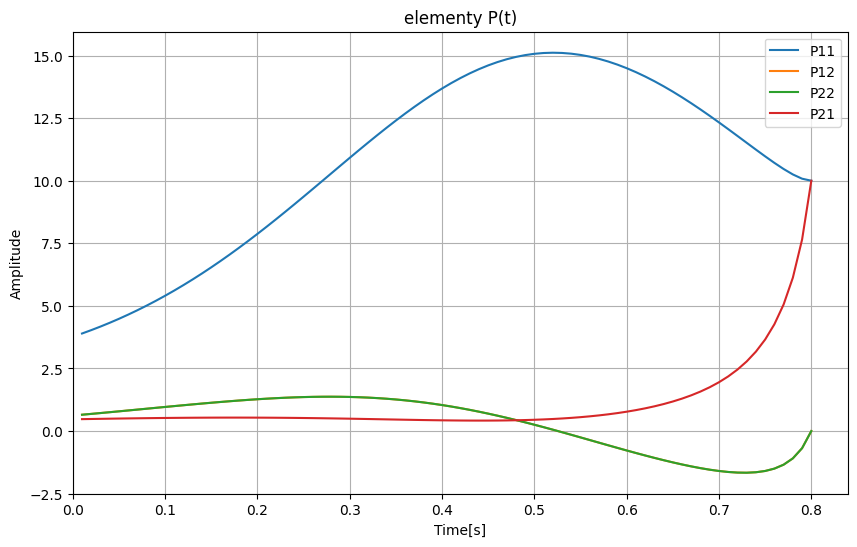

In [59]:
S = np.eye(2)*10
p0 = S.flatten()

t_r = np.arange(0.8,0,-0.01)

sol_riccati = odeint(riccati, p0, t_r)

P_t = sol_riccati

P_t_reversed = P_t[::-1] 
print(P_t_reversed)
t_reversed = t_r[::-1]

plot_sets("elementy P(t)",[t_reversed,P_t_reversed[:,0],"P11"],[t_reversed,P_t_reversed[:,1],"P12"],[t_reversed,P_t_reversed[:,2],"P22"],[t_reversed,P_t_reversed[:,3],"P21"])


In [55]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

P_interp_P11 = interp1d(t_reversed, P_t_reversed[:, 0], kind='linear', fill_value='extrapolate')
P_interp_P12 = interp1d(t_reversed, P_t_reversed[:, 1], kind='linear', fill_value='extrapolate')
P_interp_P22 = interp1d(t_reversed, P_t_reversed[:, 3], kind='linear', fill_value='extrapolate')

def get_P_t(t):
    P11 = P_interp_P11(t)
    P12 = P_interp_P12(t)
    P22 = P_interp_P22(t)
    # Macierz P musi być symetryczna
    return np.array([[P11.item(), P12.item()], [P12.item(), P22.item()]])

for i in range(len(t_reversed)):
    p_t= get_P_t(t_reversed[i])
    print(p_t)


def model_FTH(x_roz, t):
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1)

    P_t = get_P_t(t)

    K_t = R_inv @ B.T @ P_t
    
    u = -K_t @ x 
    u_mat = np.array([[u]]) 

    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    
    return x_dot_nominal

[[11.44275594  0.35245348]
 [ 0.35245348  0.56198365]]
[[11.44432154  0.3525551 ]
 [ 0.3525551   0.56199025]]
[[11.44592584  0.35265914]
 [ 0.35265914  0.561997  ]]
[[11.44756974  0.35276564]
 [ 0.35276564  0.56200389]]
[[11.44925421  0.35287465]
 [ 0.35287465  0.56201095]]
[[11.45098018  0.35298619]
 [ 0.35298619  0.56201816]]
[[11.45274864  0.35310032]
 [ 0.35310032  0.56202552]]
[[11.45456055  0.35321705]
 [ 0.35321705  0.56203304]]
[[11.45641693  0.3533364 ]
 [ 0.3533364   0.56204071]]
[[11.45831876  0.35345839]
 [ 0.35345839  0.56204854]]
[[11.46026704  0.35358304]
 [ 0.35358304  0.56205651]]
[[11.46226279  0.35371033]
 [ 0.35371033  0.56206462]]
[[11.46430699  0.35384024]
 [ 0.35384024  0.56207287]]
[[11.46640067  0.35397276]
 [ 0.35397276  0.56208125]]
[[11.46854478  0.35410782]
 [ 0.35410782  0.56208975]]
[[11.47074028  0.35424536]
 [ 0.35424536  0.56209835]]
[[11.47298811  0.35438528]
 [ 0.35438528  0.56210704]]
[[11.47528915  0.35452746]
 [ 0.35452746  0.5621158 ]]
[[11.47764

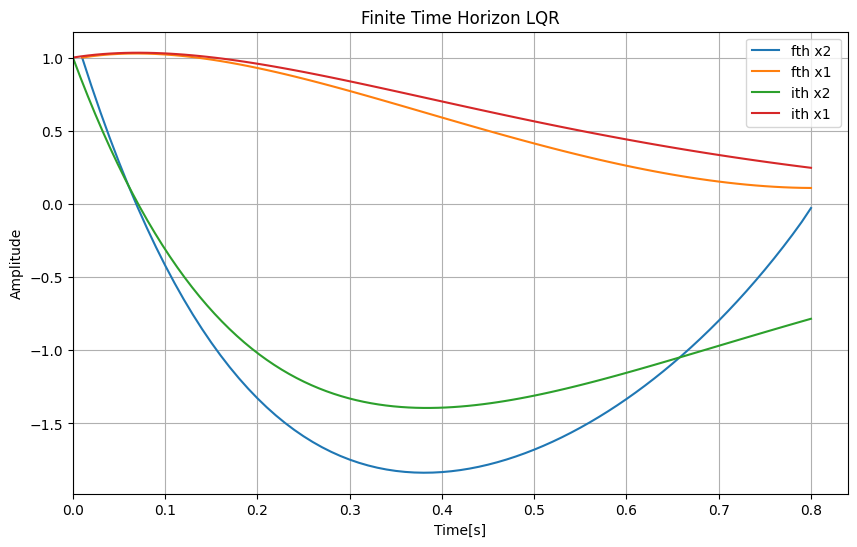

In [51]:
x0 = np.array([1, 1])

#t = np.linspace(0, 5, 1000)

x_fth = odeint(model_FTH, x0, t_reversed)

x0 = np.array([1, 1])

t = np.linspace(0, 0.8, 100)

x1 = odeint(model_with_K, x0, t,args=(K,))

plot_sets('Finite Time Horizon LQR', [t_reversed, x_fth[:,1], 'fth x2 '],[t_reversed,x_fth[:,0],"fth x1 "],[t,x1[:,1],"ith x2"],[t,x1[:,0],'ith x1'])

## Zadanie 4.2 - Sterowanie do punktu pracy (Finite Horizon)
Układ z regulatorem LQR w skończonym horyzoncie czasu dla niezerowej wartości zadanej $q_d$.

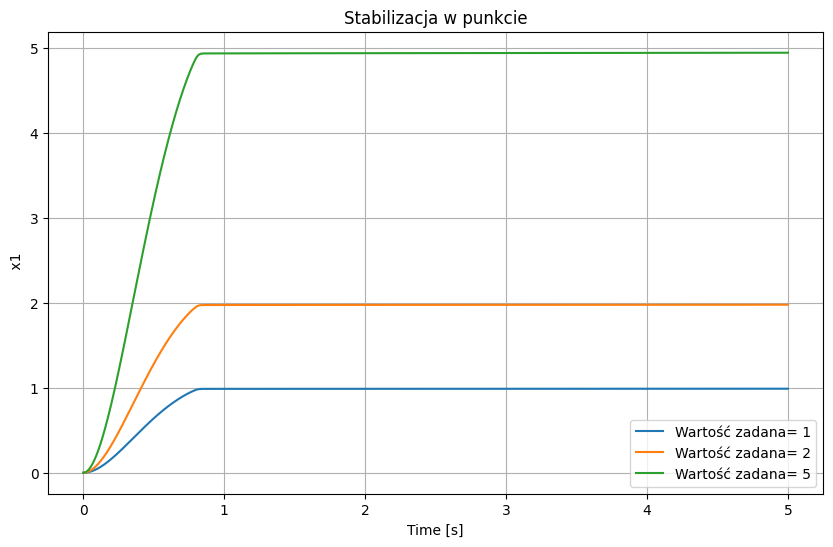

In [60]:
# Constants from previous cells
R_val = 0.5
L = 0.2
C = 0.5

# System matrices A, B are defined globally in notebook
# P_t interpolation functions are defined globally from previous steps

def model_FTH_setpoint(x_roz, t, x_d, u_d):
    # x_roz comes in as 1D array
    x = x_roz[:2]
    x_vec = x.reshape(2, 1)
    x_d_vec = x_d.reshape(2, 1)
    
    P_t = get_P_t(t)
    K_t = R_inv @ B.T @ P_t
    
    # Control Law: u = -K(x - x_d) + u_d
    u = -K_t @ (x_vec - x_d_vec) + u_d
    
    u_mat = u # scalar in (1,1) array
    
    # System dynamics: dx = Ax + Bu
    dx = A @ x_vec + B @ u_mat
    
    return dx.flatten()

# Simulation Loop
q_targets = [1, 2, 5]
t_sim = np.linspace(0, 5, 1000)
x0 = np.array([0, 0]) # Start from zero

plt.figure(figsize=(10, 6))
plt.title(f"Stabilizacja w punkcie")

for q_d in q_targets:
    # Calculate steady state targets
    # x1 = q, x2 = q_dot. Steady state: x2=0, x1=q_d
    x_d = np.array([q_d, 0])
    
    # Equilibrium: Ax_d + Bu_d = 0
    # Row 2: -1/(LC)*x1 - R/L*x2 + 1/L*u = 0
    # -1/(0.1)*q_d + 5*u_d = 0  => -10*q_d + 5*u_d = 0 => u_d = 2*q_d
    # Or generically: u_d = (1/L)^-1 * (1/(LC)*x1 + R/L*x2)
    # u_d = L * ( x1/(LC) ) = x1/C = q_d / 0.5 = 2*q_d
    u_d = q_d / C
    
    x_sim = odeint(model_FTH_setpoint, x0, t_sim, args=(x_d, u_d))
    
    # Output y = x1 (position/charge)
    y_sim = x_sim[:, 0]
    plt.plot(t_sim, y_sim, label=f'Wartość zadana= {q_d}')

plt.xlabel("Time [s]")
plt.ylabel(" x1")
plt.grid(True)
plt.legend()
plt.show()


Infinite Horizon K: [[0.23606798 0.65949437]]


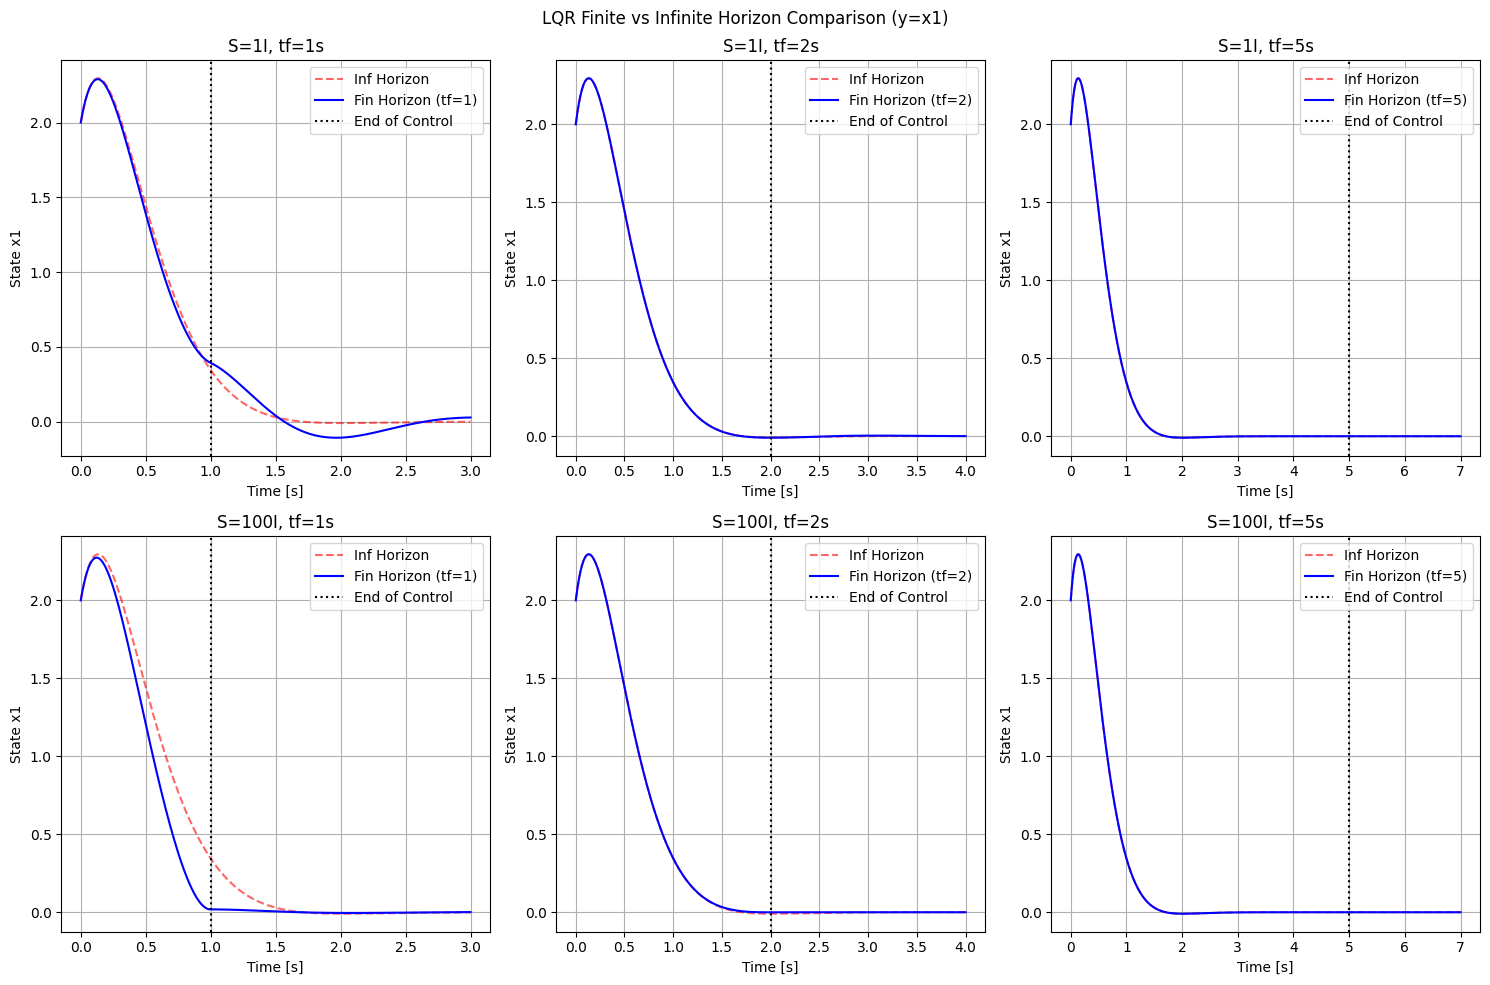

Analysis: Finite horizon controller converges towards the infinite horizon path (turnpike property) when time horizon is large enough.
However, near the end of the horizon (tf), the finite controller deviates to minimize terminal cost S.
If S is small (e.g., I), deviation is larger. If S is large (100*I ~ approximating inf cost), it stays closer.


In [19]:
# LQR Comparison: Infinite vs Finite Horizon
from scipy.linalg import solve_continuous_are, inv
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# System Definitions (RLC Model from notebook)
R_sys = 0.5
L = 0.2
C = 0.5

A = np.array([[0, 1], [-1/(L*C), -R_sys/L]])
B = np.array([[0], [1/L]])

# User Parameters for LQR
Q = np.eye(2)     # Cost Q = I
R_lqr = 1         # Cost R = 1
S_factor = [1, 100]  # S = 1*I or 100*I
tf_list = [1, 2, 5]  # Time horizons

# --- 1. Infinite Horizon LQR ---
P_inf = solve_continuous_are(A, B, Q, R_lqr)
K_inf = inv([[R_lqr]]) @ B.T @ P_inf
print(f"Infinite Horizon K: {K_inf}")

def model_lqr_inf(x, t):
    u = -K_inf @ x
    dx = A @ x + B @ u
    return dx.flatten()

x0 = np.array([2.0, 5.0]) # Initial state

# --- 2. Finite Horizon LQR & Comparison ---
plt.figure(figsize=(15, 10))
plot_idx = 1

for s_mult in S_factor:
    S = s_mult * np.eye(2)
    for tf in tf_list:
        # Solve DRE backwards: dP/dtau = A.T P + P A - P B R^-1 B.T P + Q
        # tau = tf - t goes from 0 to tf
        def riccati_rhs(P_flat, tau):
            P = P_flat.reshape(2, 2)
            dP = A.T @ P + P @ A - P @ B @ inv([[R_lqr]]) @ B.T @ P + Q
            return dP.flatten()
        
        tau_span = np.linspace(0, tf, 200)
        P_sol = odeint(riccati_rhs, S.flatten(), tau_span)
        
        # Function to get K(t) from interpolated P(tau)
        def get_K(t):
            tau = tf - t
            if tau < 0: tau = 0
            if tau > tf: tau = tf
            # Simple nearest index for now (or could use interp1d)
            idx = int(tau / tf * (len(tau_span) - 1))
            P_val = P_sol[idx].reshape(2, 2)
            val = inv([[R_lqr]]) @ B.T @ P_val
            return val

        def model_lqr_fin(x, t):
             if t > tf:
                 return (A @ x).flatten() # Free response after control ends
             K_t = get_K(t)
             u = -K_t @ x
             dx = A @ x + B @ u
             return dx.flatten()
        
        # Comparison Simulation
        t_sim = np.linspace(0, tf + 2, 500) # Sim longer than tf to see effect
        
        x_inf = odeint(model_lqr_inf, x0, t_sim)
        x_fin = odeint(model_lqr_fin, x0, t_sim)
        
        plt.subplot(2, 3, plot_idx)
        plt.plot(t_sim, x_inf[:, 0], 'r--', label='Inf Horizon', alpha=0.6)
        plt.plot(t_sim, x_fin[:, 0], 'b-', label=f'Fin Horizon (tf={tf})')
        plt.axvline(x=tf, color='k', linestyle=':', label='End of Control')
        plt.title(f"S={s_mult}I, tf={tf}s")
        plt.xlabel("Time [s]")
        plt.ylabel("State x1")
        plt.legend()
        plt.grid(True)
        plot_idx += 1

plt.suptitle("LQR Finite vs Infinite Horizon Comparison (y=x1)")
plt.tight_layout()
plt.show()

print("Analysis: Finite horizon controller converges towards the infinite horizon path (turnpike property) when time horizon is large enough.")
print("However, near the end of the horizon (tf), the finite controller deviates to minimize terminal cost S.")
print("If S is small (e.g., I), deviation is larger. If S is large (100*I ~ approximating inf cost), it stays closer.")